In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
# from sktime.forecasting.model_selection import temporal_train_test_split
from pmdarima import AutoARIMA
# from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [2]:
df = pd.read_csv('../air-traffic-prediction/AirtrafficA4.csv')
df = df.dropna()
df['DATE'] = df['YEAR'].astype(str) + '-' + df['MONTH']
df['TOTAL DEPARTURES'] = df['TOTAL DEPARTURES'].str.replace(',', '').astype(float)
df['HOURS FLOWN'] = q = df['HOURS FLOWN'].str.replace(',', '').astype(float)
df['KILOMETRE FLOWN'] = df['KILOMETRE FLOWN'].str.replace(',', '').astype(float)
df['PASSENGERS CARRIED'] = df['PASSENGERS CARRIED'].str.replace(',', '').astype(float)
df['AVAILABLE SEAT KILOMETRE (IN THOUSAND)'] = df['AVAILABLE SEAT KILOMETRE (IN THOUSAND)'].str.replace(',', '').astype(float)
df[' FREIGHT CARRIED (IN TONNE)'] = df[' FREIGHT CARRIED (IN TONNE)'].str.replace(',', '').astype(float)
df['MAIL CARRIED (IN TONNE)'] = df['MAIL CARRIED (IN TONNE)'].str.replace(',', '').astype(float)
df.rename(columns={' FREIGHT CARRIED (IN TONNE)': 'FREIGHT CARRIED (IN TONNE)'}, inplace=True)

df['MONTH'] = df['MONTH'].str.strip()
df['MONTH'] = df['MONTH'].map({'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUNE': 6, 'JULY': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12})

#sorting df on the basis of year
df = df.sort_values(by=['YEAR', 'MONTH'])

df['SEASONAL_DIFF'] = df['PASSENGERS CARRIED'] - df['PASSENGERS CARRIED'].shift(12)
df['SEASONAL_DIFF'] = df['SEASONAL_DIFF'] - df['SEASONAL_DIFF'].shift(1)

df['log_PASSENGERS_CARRIED'] = np.log(df['PASSENGERS CARRIED'])
df['log_PASSENGERS_CARRIED'] = df['log_PASSENGERS_CARRIED'] - df['log_PASSENGERS_CARRIED'].shift(1)

df['sqrt_PASSENGERS_CARRIED'] = np.sqrt(df['PASSENGERS CARRIED'])

df['cubert_PASSENGERS_CARRIED'] = np.cbrt(df['PASSENGERS CARRIED'])


In [3]:
# ARIMA model 
model = AutoARIMA(seasonal=True ,sp=12, trace=True)
# model = AutoARIMA(seasonal=True, m=12, trace=True, 
#                    order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))

# y = df['PASSENGERS CARRIED'].dropna()
# y = df['SEASONAL_DIFF'].dropna()
y = df['log_PASSENGERS_CARRIED'].dropna()
# y = df['sqrt_PASSENGERS_CARRIED'].dropna()
# y = df['cubert_PASSENGERS_CARRIED'].dropna()

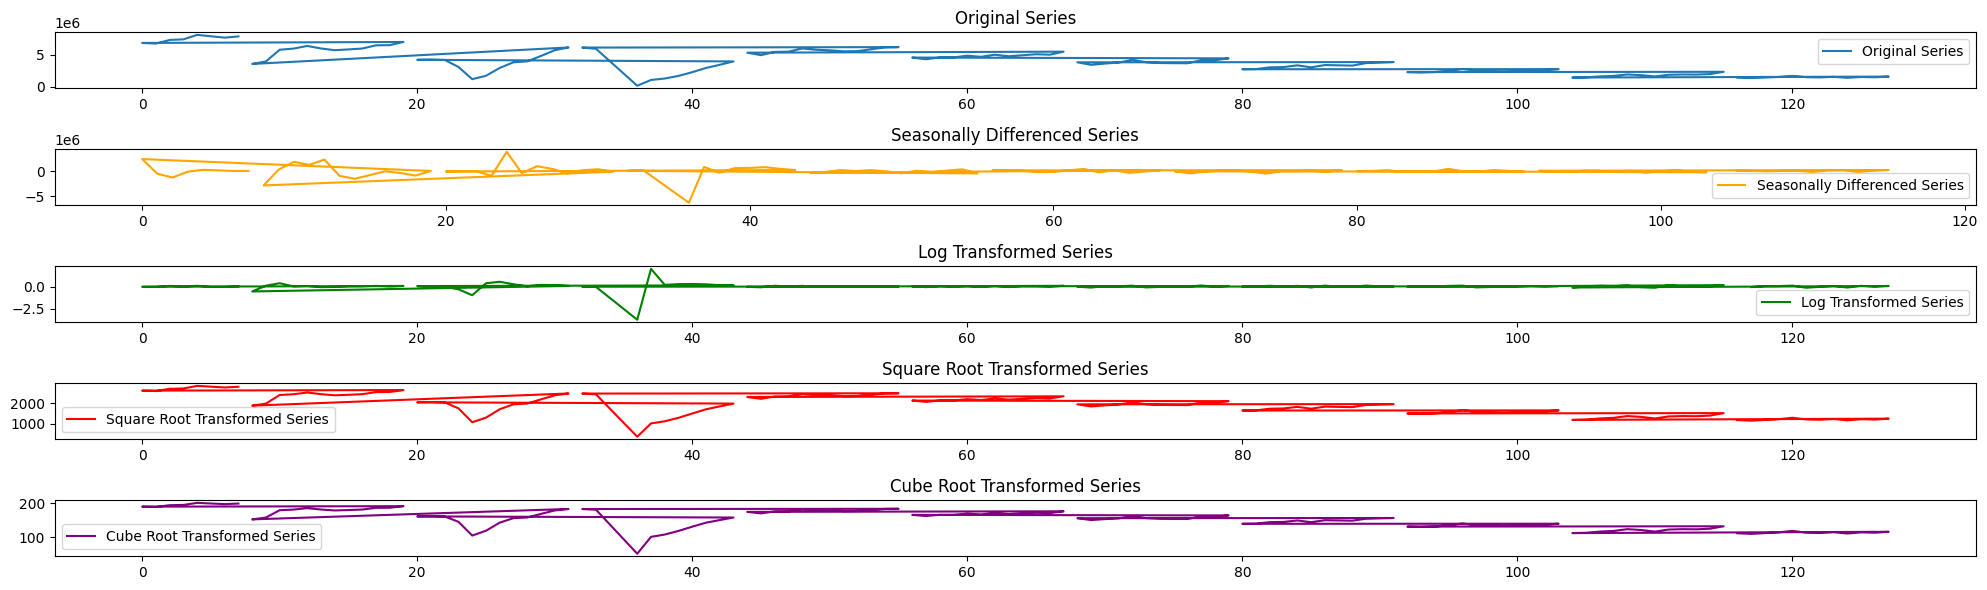

In [4]:
plt.figure(figsize=(20, 6))
plt.subplot(5, 1, 1)
plt.plot(df['PASSENGERS CARRIED'], label='Original Series')
plt.title('Original Series')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(df['SEASONAL_DIFF'], label='Seasonally Differenced Series', color='orange')
plt.title('Seasonally Differenced Series')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(df['log_PASSENGERS_CARRIED'], label='Log Transformed Series', color='green')
plt.title('Log Transformed Series')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(df['sqrt_PASSENGERS_CARRIED'], label='Square Root Transformed Series', color='red')
plt.title('Square Root Transformed Series')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(df['cubert_PASSENGERS_CARRIED'], label='Cube Root Transformed Series', color='purple')
plt.title('Cube Root Transformed Series')
plt.legend()

plt.tight_layout()
plt.show()


In [5]:
model.fit(y)
forecast_steps = 12
y_pred_diff = model.predict(forecast_steps)

y_pred = np.exp(y_pred_diff)
last_value = df['PASSENGERS CARRIED'].iloc[-1]
y_pred = y_pred + last_value


# y_pred = y_pred_diff ** 3

forecast_index = pd.period_range(start='2023-09', periods=forecast_steps, freq='M')
forecast_dates = [date.strftime('%Y %b').upper() for date in forecast_index]

forecast_df = pd.DataFrame({
    'YEAR_MONTH': forecast_dates,
    'PASSENGERS CARRIED': y_pred
})

print("YEAR_MONTH,PASSENGERS CARRIED")
for _, row in forecast_df.iterrows():
    print(f"{row['YEAR_MONTH']},{row['PASSENGERS CARRIED']}")


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=115.875, Time=1.82 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=133.910, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=123.253, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=118.684, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=132.053, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.96 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.26 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=113.463, Time=0.73 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=117.138, Time=0.41 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=122.622, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=113.633, Time=0.22 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 10.710 seconds
YEAR_MONTH,PASSENGERS CARRIED
2023 SEP,7867259.986

c:\Users\VICTUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\VICTUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\VICTUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['sp']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [6]:
forecast_df.to_csv('forecast.csv', index=False)